# Gradient Boosting Regressor


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
data1 = pd.read_csv("../mihiresh/commerce_logic.csv")

In [3]:
features = ['years_to_retire', 'salary', 'investment_amount', 'current_savings', 'debt',
            'other_expenses', 'number_of_dependents', 'current_invested_amount', 'house_ownership']

# Targets for percentage allocations
targets_low = ['s1_low', 's2_low', 's3_low', 's4_low', 's5_low', 's6_low']
targets_mid = ['s1_mid', 's2_mid', 's3_mid', 's4_mid', 's5_mid', 's6_mid']
targets_high = ['s1_high', 's2_high', 's3_high', 's4_high', 's5_high', 's6_high']

In [4]:
# Preprocessing
X = data1[features]
y_low = data1[targets_low]
y_mid = data1[targets_mid]
y_high = data1[targets_high]

In [5]:
# Normalize target values to sum to 1
y_low = y_low.div(y_low.sum(axis=1), axis=0)
y_mid = y_mid.div(y_mid.sum(axis=1), axis=0)
y_high = y_high.div(y_high.sum(axis=1), axis=0)

In [6]:
# Handle categorical variables
categorical_features = ['house_ownership']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Transform the data
X_processed = preprocessor.fit_transform(X)

In [7]:
# Split the data
X_train, X_test, y_train_low, y_test_low = train_test_split(X_processed, y_low, test_size=0.2, random_state=42)
_, _, y_train_mid, y_test_mid = train_test_split(X_processed, y_mid, test_size=0.2, random_state=42)
_, _, y_train_high, y_test_high = train_test_split(X_processed, y_high, test_size=0.2, random_state=42)

In [8]:
# Train and evaluate models for each risk level
def train_and_evaluate(X_train, X_test, y_train, y_test, risk_level):
    models = {}
    for target in y_train.columns:
        model = GradientBoostingRegressor(random_state=42)
        model.fit(X_train, y_train[target])
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test[target], y_pred)
        models[target] = model
        print(f'{risk_level} - MAE for {target}: {mae}')
    return models

In [9]:
low_models = train_and_evaluate(X_train, X_test, y_train_low, y_test_low, 'Low')
mid_models = train_and_evaluate(X_train, X_test, y_train_mid, y_test_mid, 'Mid')
high_models = train_and_evaluate(X_train, X_test, y_train_high, y_test_high, 'High')

Low - MAE for s1_low: 0.04145885862420769
Low - MAE for s2_low: 0.0120480435030057
Low - MAE for s3_low: 0.024526949663663027
Low - MAE for s4_low: 0.011897970166384126
Low - MAE for s5_low: 0.02435982686067356
Low - MAE for s6_low: 0.02460444922108109
Mid - MAE for s1_mid: 0.040972159837673605
Mid - MAE for s2_mid: 0.011813653698194319
Mid - MAE for s3_mid: 0.024224464764362047
Mid - MAE for s4_mid: 0.023618627189040408
Mid - MAE for s5_mid: 0.023873971176058256
Mid - MAE for s6_mid: 0.023809097579230477
High - MAE for s1_high: 0.051150638635850496
High - MAE for s2_high: 0.024930724066321325
High - MAE for s3_high: 0.01211885965743685
High - MAE for s4_high: 0.012151120027945774
High - MAE for s5_high: 0.03751380572969898
High - MAE for s6_high: 0.025008064183815633


In [10]:
# Predict using the models
def predict(models, X):
    predictions = {}
    for target, model in models.items():
        predictions[target] = model.predict(X)
    return predictions

low_predictions = predict(low_models, X_test)
mid_predictions = predict(mid_models, X_test)
high_predictions = predict(high_models, X_test)

In [11]:
def display_results(employee_data, low_pred, mid_pred, high_pred):
    print("Low Risk:")
    for i, investment in enumerate(low_pred.keys()):
        print(f"{investment}: {low_pred[investment][0]*100:.2f}%")
    print("Medium Risk:")
    for i, investment in enumerate(mid_pred.keys()):
        print(f"{investment}: {mid_pred[investment][0]*100:.2f}%")
    print("High Risk:")
    for i, investment in enumerate(high_pred.keys()):
        print(f"{investment}: {high_pred[investment][0]*100:.2f}%")

In [12]:
# Example new employee data
new_employee = pd.DataFrame([[30, 45000, 12000, 35000, 2000, 3000, 1, 1, 'Own House']], columns=features)
new_employee_processed = preprocessor.transform(new_employee)

predicted_low = predict(low_models, new_employee_processed)
predicted_mid = predict(mid_models, new_employee_processed)
predicted_high = predict(high_models, new_employee_processed)

display_results(new_employee, predicted_low, predicted_mid, predicted_high)

Low Risk:
s1_low: 7.78%
s2_low: 2.08%
s3_low: 24.37%
s4_low: 16.84%
s5_low: 39.51%
s6_low: 9.41%
Medium Risk:
s1_mid: 5.73%
s2_mid: 6.98%
s3_mid: 14.38%
s4_mid: 24.24%
s5_mid: 19.24%
s6_mid: 29.18%
High Risk:
s1_high: 31.16%
s2_high: 29.58%
s3_high: 7.01%
s4_high: 6.99%
s5_high: 6.29%
s6_high: 19.03%


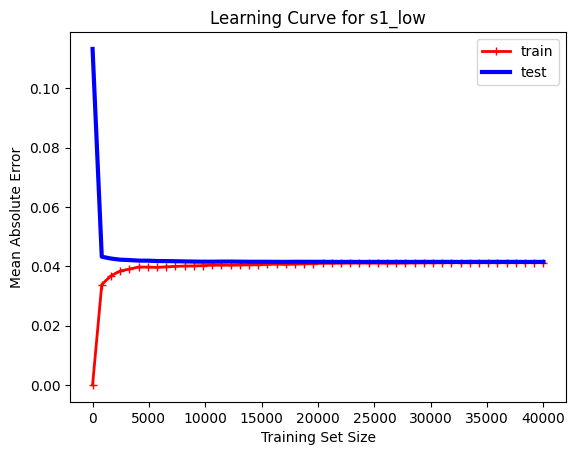

In [17]:
import matplotlib.pyplot as plt
def plot_learning_curve(model, X_train, y_train, X_test, y_test, target, steps=50):
    train_errors, test_errors = [], []
    m_values = np.linspace(1, len(X_train), steps, dtype=int)
    for m in m_values:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_absolute_error(y_train[:m], y_train_predict))
        test_errors.append(mean_absolute_error(y_test, y_test_predict))
    
    plt.plot(m_values, train_errors, "r-+", linewidth=2, label="train")
    plt.plot(m_values, test_errors, "b-", linewidth=3, label="test")
    plt.legend()
    plt.title(f"Learning Curve for {target}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Absolute Error")
    plt.show()

# Plot learning curves for one of the targets as an example
plot_learning_curve(low_models['s1_low'], X_train, y_train_low['s1_low'], X_test, y_test_low['s1_low'], 's1_low', steps=50)

In [19]:
!pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 656.4 kB/s eta 0:02:32
   ---------------------------------------- 0.3/99.8 MB 2.2 MB/s eta 0:00:45
   ---------------------------------------- 1.1/99.8 MB 6.3 MB/s eta 0:00:16
    --------------------------------------- 2.0/99.8 MB 9.0 MB/s eta 0:00:11
   - -------------------------------------- 3.4/99.8 MB 12.7 MB/s eta 0:00:08
   - -------------------------------------- 3.8/99.8 MB 13.4 MB/s eta 0:00:08
   - -------------------------------------- 4.4/99.8 MB 12.3 MB/s eta 0:00:08
   - -------------------------------------- 4.9/99.8 MB 12.7 MB/s eta 0:00:08
   -- ------------------------------------- 5.7/99.8 MB 12.6 MB/s eta 0:00:08
   -- ------------------------------------- 6.5/99.8 MB 13.0 MB/s eta 0:00:08
   -- ------------------------------------- 6.9/99.8 MB 13.0 MB/s eta 0:00:08
   -

In [21]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Define the models to compare
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR()
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_low['s1_low'], test_size=0.2, random_state=42)

# Evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = mae
    print(f'{name} - MAE: {mae}')

# Display the results
print("\nModel Performance:")
for name, mae in results.items():
    print(f"{name}: {mae}")

Ridge - MAE: 0.041451971000136215
Lasso - MAE: 0.0414553103
ElasticNet - MAE: 0.0414553103
Decision Tree - MAE: 0.05808900000000001
Random Forest - MAE: 0.04217235
Gradient Boosting - MAE: 0.0414616233715646
XGBoost - MAE: 0.04215384623048454
SVR - MAE: 0.04507545099781603

Model Performance:
Ridge: 0.041451971000136215
Lasso: 0.0414553103
ElasticNet: 0.0414553103
Decision Tree: 0.05808900000000001
Random Forest: 0.04217235
Gradient Boosting: 0.0414616233715646
XGBoost: 0.04215384623048454
SVR: 0.04507545099781603


In [22]:
from sklearn.model_selection import GridSearchCV

# Example of hyperparameter tuning with GridSearchCV for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

# Neural Network Based

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
# Load the dataset
file_path = '../mihiresh/commerce_logic.csv'
data = pd.read_csv(file_path)

# Features and target columns
features = ['years_to_retire', 'salary', 'investment_amount', 'current_savings', 'debt',
            'other_expenses', 'number_of_dependents', 'current_invested_amount']

# Targets for percentage allocations
targets_low = ['s1_low', 's2_low', 's3_low', 's4_low', 's5_low', 's6_low']
targets_mid = ['s1_mid', 's2_mid', 's3_mid', 's4_mid', 's5_mid', 's6_mid']
targets_high = ['s1_high', 's2_high', 's3_high', 's4_high', 's5_high', 's6_high']


In [4]:
# Preprocessing
X = data[features]
y_low = data[targets_low]
y_mid = data[targets_mid]
y_high = data[targets_high]

In [5]:
y_low

,s1_low,s2_low,s3_low,s4_low,s5_low,s6_low
0,9,0,22,16,42,11
1,10,0,28,18,38,6
2,5,3,28,17,42,5
3,14,3,21,18,36,8
4,4,1,26,16,44,9
...,...,...,...,...,...,...
49995,16,4,21,15,37,7
49996,12,3,27,17,35,6
49997,5,2,26,19,38,10
49998,12,3,26,16,36,7


In [10]:
# Normalize target values to sum to 1
y_low = y_low.div(y_low.sum(axis=1), axis=0)
y_mid = y_mid.div(y_mid.sum(axis=1), axis=0)
y_high = y_high.div(y_high.sum(axis=1), axis=0)


In [12]:
numerical_features = [col for col in features]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ])

# Transform the data
X_processed = preprocessor.fit_transform(X)


In [13]:
# Split the data
X_train, X_test, y_train_low, y_test_low = train_test_split(X_processed, y_low, test_size=0.2, random_state=42)
_, _, y_train_mid, y_test_mid = train_test_split(X_processed, y_mid, test_size=0.2, random_state=42)
_, _, y_train_high, y_test_high = train_test_split(X_processed, y_high, test_size=0.2, random_state=42)

# Define the model
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu')(input_layer)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)


In [14]:
input_layer

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'input_1')>

In [16]:
x

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_1')>

In [17]:
# Output layers for low, mid, and high risk levels
low_output = Dense(6, activation='sigmoid', name='low_output')(x)
mid_output = Dense(6, activation='sigmoid', name='mid_output')(x)
high_output = Dense(6, activation='sigmoid', name='high_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=[low_output, mid_output, high_output])


In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='mean_squared_error',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Train the model with early stopping
history = model.fit(X_train, [y_train_low, y_train_mid, y_train_high],
                    epochs=150, batch_size=8, validation_data=(X_test, [y_test_low, y_test_mid, y_test_high]),
                    callbacks=[early_stopping, reduce_lr])
# Evaluate the model
loss, low_loss, mid_loss, high_loss, low_acc, mid_acc, high_acc = model.evaluate(X_test, [y_test_low, y_test_mid, y_test_high])
print(f"Test Low Accuracy: {low_acc}, Test Mid Accuracy: {mid_acc}, Test High Accuracy: {high_acc}")


Epoch 1/150


5000/5000 [==============================] - 12s 2ms/step - loss: 0.0039 - low_output_loss: 0.0011 - mid_output_loss: 0.0012 - high_output_loss: 0.0016 - low_output_accuracy: 0.9984 - mid_output_accuracy: 0.8458 - high_output_accuracy: 0.5108 - val_loss: 0.0032 - val_low_output_loss: 8.9197e-04 - val_mid_output_loss: 9.6273e-04 - val_high_output_loss: 0.0013 - val_low_output_accuracy: 1.0000 - val_mid_output_accuracy: 0.8489 - val_high_output_accuracy: 0.5481 - lr: 0.0100
Epoch 2/150
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0032 - low_output_loss: 9.0148e-04 - mid_output_loss: 9.5915e-04 - high_output_loss: 0.0013 - low_output_accuracy: 1.0000 - mid_output_accuracy: 0.8496 - high_output_accuracy: 0.5164 - val_loss: 0.0032 - val_low_output_loss: 8.9674e-04 - val_mid_output_loss: 9.4362e-04 - val_high_output_loss: 0.0013 - val_low_output_accuracy: 1.0000 - val_mid_output_accuracy: 0.8489 - val_high_output_accuracy: 0.5481 - lr: 0.0100
Epoch 3/150
5

In [19]:
# Predict using the model
low_pred, mid_pred, high_pred = model.predict(X_test)

# Function to display results
def display_results(employee_data, low_pred, mid_pred, high_pred):
    print("Low Risk:")
    print(f"s1: {low_pred[0]*100:.2f}%, s2: {low_pred[1]*100:.2f}%, s3: {low_pred[2]*100:.2f}%, s4: {low_pred[3]*100:.2f}%, s5: {low_pred[4]*100:.2f}%, s6: {low_pred[5]*100:.2f}%")
    print("Medium Risk:")
    print(f"s1: {mid_pred[0]*100:.2f}%, s2: {mid_pred[1]*100:.2f}%, s3: {mid_pred[2]*100:.2f}%, s4: {mid_pred[3]*100:.2f}%, s5: {mid_pred[4]*100:.2f}%, s6: {mid_pred[5]*100:.2f}%")
    print("High Risk:")
    print(f"s1: {high_pred[0]*100:.2f}%, s2: {high_pred[1]*100:.2f}%, s3: {high_pred[2]*100:.2f}%, s4: {high_pred[3]*100:.2f}%, s5: {high_pred[4]*100:.2f}%, s6: {high_pred[5]*100:.2f}%")

# Example new employee data
new_employee = pd.DataFrame([[30, 45000, 12000, 35000, 2000, 3000, 1, 1]], columns=features)
new_employee_processed = preprocessor.transform(new_employee)
predicted_low, predicted_mid, predicted_high = model.predict(new_employee_processed)

display_results(new_employee, predicted_low[0], predicted_mid[0], predicted_high[0])

1/1 [==============================] - 0s 24ms/step
Low Risk:
s1: 8.49%, s2: 2.55%, s3: 25.28%, s4: 17.86%, s5: 39.88%, s6: 10.34%
Medium Risk:
s1: 6.35%, s2: 7.86%, s3: 15.35%, s4: 25.08%, s5: 20.33%, s6: 29.84%
High Risk:
s1: 30.61%, s2: 30.05%, s3: 7.91%, s4: 7.94%, s5: 7.83%, s6: 20.09%


In [20]:
model.save("investment_recommendation.h5")
import joblib
joblib.dump(preprocessor,'preprocessor_pipeline.pkl')

c:\Users\Anand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['preprocessor_pipeline.pkl']